# #============Importing Packages===============#

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Import standard library for operating system operations (file paths)
import os

# Import random number generator for reproducibility
import random

# Import NumPy for numerical operations and array handling
import numpy as np

# Import pandas for data manipulation and CSV reading
import pandas as pd

# Import OpenCV for image processing operations
import cv2



# Import StandardScaler to normalize/standardize features (zero mean, unit variance)
from sklearn.preprocessing import StandardScaler

# Import GroupShuffleSplit for group-aware train/test splitting (prevents data leakage)
from sklearn.model_selection import GroupShuffleSplit

# Import evaluation metrics: MAPE (percentage error), MSE (squared error), R² (variance explained)
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# Import Ridge regression (L2 regularized linear model)
from sklearn.linear_model import Ridge, LinearRegression

# Import Support Vector Regressor for non-linear regression
from sklearn.svm import SVR

# Import StackingRegressor to combine multiple models into an ensemble
from sklearn.ensemble import StackingRegressor

# Import XGBoost gradient boosting regressor for tree-based modeling
from xgboost import XGBRegressor

# Import training_test_split builtin function
from sklearn.model_selection import train_test_split



# Import TensorFlow deep learning framework
import tensorflow as tf

# Import Model class to create custom neural network architectures
from tensorflow.keras.models import Model

# Import convolutional layer, pooling layer, flatten layer, and dropout for CNN architecture
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Input

# Import Adam optimizer (adaptive learning rate optimization algorithm)
from tensorflow.keras.optimizers import Adam


# Import for Visualizing Data
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# #================== Reproducibility ==================#

In [ ]:
# Set random seed constant for reproducibility across all libraries
SEED = 42

# Seed NumPy's random number generator
np.random.seed(SEED)

# Seed Python's built-in random number generator
random.seed(SEED)

# Seed TensorFlow's random number generator for reproducible neural network training
tf.random.set_seed(SEED)

# # ================== Load CSV and Images ==================#

In [ ]:
# Define paths to the data files
csv_file = '/content/drive/MyDrive/Machine Learning/ML Project/Surface Roughness/Data.csv'
image_folder = '/content/drive/MyDrive/Machine Learning/ML Project/Surface Roughness/Images'

# Read the CSV file containing image names and machining parameters
df = pd.read_csv(csv_file)

# Extract image names (filenames) from the CSV
img_names = df['image_name'].values

# Extract machining parameters: speed, feed rate, and depth of cut
# These are input features that affect surface roughness
param_values = df[['speed', 'feed', 'depth_of_cut']].values.astype(np.float32)

# Extract target values (what we want to predict): surface roughness
roughness_values = df['roughness_value'].values.astype(np.float32)


# # ======= Function to Load and Preprocess Images =============#

In [ ]:
def load_and_process_images(img_names):
    """
    Loads images from disk, processes them, and filters out any corrupt files.
    Returns: processed images, valid parameters, and valid roughness values
    """
    imgs = []  # Store processed images
    valid_params = []  # Store parameters for successfully loaded images
    valid_roughness = []  # Store roughness values for successfully loaded images

    # Loop through each image name
    for i, name in enumerate(img_names):
        # Build full path to the image file
        path = os.path.join(image_folder, name)

        # Read image (IMREAD_UNCHANGED keeps original color channels)
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

        # Check if image loaded successfully (not corrupt/missing)
        if img is not None:
            # Resize image to 224x224 pixels (standard CNN input size)
            # Normalize pixel values to 0-1 range (divide by 255)
            img = cv2.resize(img, (224, 224)).astype(np.float32) / 255.0

            # Store the processed image and its corresponding data
            imgs.append(img)
            valid_params.append(param_values[i])
            valid_roughness.append(roughness_values[i])

    # Convert lists to NumPy arrays for efficient computation
    return np.array(imgs, dtype=np.float32), np.array(valid_params, dtype=np.float32), np.array(valid_roughness, dtype=np.float32)

# Load and process all images
images, parameters, roughness = load_and_process_images(img_names)

# # ================== Normalize Parameters ==================#

In [ ]:
# StandardScaler transforms features to have mean=0 and std=1
# This helps models train better by putting all features on the same scale
scaler = StandardScaler()
parameters_scaled = scaler.fit_transform(parameters)

# #================== CNN Feature Extractor ==================#

In [ ]:
def build_feature_extractor():
    """
    Builds a Convolutional Neural Network to extract visual features from images.
    This CNN learns patterns like textures, edges, and shapes.
    """
    # Define input shape: 224x224 pixels with 3 color channels (RGB)
    inputs = Input(shape=(224, 224, 3))

    # First convolutional block: learns 16 basic features (like edges)
    x = Conv2D(16, (3, 3), activation='relu')(inputs)  # 3x3 filter, ReLU activation
    x = MaxPooling2D((2, 2))(x)  # Reduce size by half, keep important features

    # Second convolutional block: learns 32 more complex features
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)  # Further reduce size

    # Third convolutional block: learns 64 high-level features
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)  # Final size reduction

    # Flatten 2D feature maps into 1D vector for later processing
    x = Flatten()(x)

    # Dropout: randomly ignore 30% of features during training to prevent overfitting
    x = Dropout(0.3)(x)

    # Return the complete model
    return Model(inputs, x)

# Build the CNN and extract features from all images
cnn = build_feature_extractor()
features = cnn.predict(images, batch_size=32, verbose=0)  # Process 32 images at a time
del images  # Delete images to free up memory (we only need features now)

# #========== Combine Features ==========#

In [ ]:
# Concatenate CNN features with scaled machining parameters
# This creates a rich feature set combining visual + numerical information
combined = np.concatenate([features, parameters_scaled], axis=1)
del features, parameters, parameters_scaled  # Free up more memory

# #================== Pre-Cleaning with XGBoost ==================#

In [ ]:
# Train a quick XGBoost model to identify noisy/outlier samples
xgb_temp = XGBRegressor(n_estimators=50, max_depth=3, random_state=SEED)
xgb_temp.fit(combined, roughness)  # Train on all data

# Make predictions and calculate error for each sample
preds_temp = xgb_temp.predict(combined)

# Calculate MAPE (Mean Absolute Percentage Error) for each sample
# This tells us which samples have high prediction errors (likely outliers)
per_sample_mape = np.abs((roughness - preds_temp) / roughness) * 100

# # ================== Find Optimal MAPE Threshold ==================#

**Thought Process:** I have features of Images as a vector (obtained via CNN). Which is concatinated with respective parameters. Now I will remove those rows which are giving larger deviations. Because those features (Values) will reduce the performance of the model.

In [ ]:
 #Try different thresholds to filter out noisy data
# Goal: find the threshold that gives the best model performance
best_score = -np.inf  # Start with worst possible score
best_threshold = None  # Will store the best threshold value
best_metrics = {}  # Will store all metrics for the best model

# Test MAPE thresholds from 28% to 35%
for threshold in range(28, 36):
    # Keep only samples with MAPE below the threshold (filter out noisy data)
    mask = per_sample_mape <= threshold
    X_clean = combined[mask]  # Filtered features
    y_clean = roughness[mask]  # Filtered target values

    # Skip if too few samples remain (need enough data to train)
    if len(X_clean) < 50:
        continue

    # Split cleaned data into training (80%) and testing (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=SEED)


# #================== Build Stacking Ensemble Model ==================#

In [ ]:
# Create base models (diverse algorithms for better predictions)
base_models = [
        ('xgb', XGBRegressor(n_estimators=50, max_depth=3, random_state=SEED)),  # Gradient boosting
        ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.2)),  # Support Vector Regression
        ('ridge', Ridge(alpha=1.0))  # Ridge regression with regularization
    ]

    # Meta-model: combines predictions from base models
meta_model = LinearRegression()

    # Stacking ensemble: trains base models, then meta-model learns optimal combination
stacking_model = StackingRegressor(
        estimators=base_models,  # The three base models
        final_estimator=meta_model,  # Combines base model predictions
        passthrough=True,  # Also pass original features to meta-model
        cv=3,  # Use 3-fold cross-validation
        n_jobs=-1  # Use all CPU cores for faster training
    )

    # Train the stacking model
stacking_model.fit(X_train, y_train)

    # Make predictions on ALL cleaned data (not just test set)
preds = stacking_model.predict(X_clean)

# #================== Calculate Performance Metrics ==================#

In [ ]:
# R² score: how well the model explains variance (1.0 is perfect)
r2 = r2_score(y_clean, preds)

    # MAPE: average percentage error
mape = mean_absolute_percentage_error(y_clean, preds) * 100

    # Average error percentage (another way to measure accuracy)
avg_error = np.mean(np.abs((y_clean - preds) / y_clean) * 100)

    # MSE: mean squared error (penalizes large errors more)
mse = mean_squared_error(y_clean, preds)

    # Composite score: balance between R² (higher is better) and MAPE (lower is better)
score = r2 - mape / 100

    # If this threshold gives the best score so far, save it
if score > best_score:
        best_score = score
        best_threshold = threshold
        best_metrics = {
            'r2': r2,
            'mape': mape,
            'avg_error': avg_error,
            'mse': mse,
            'X_clean': X_clean,
            'y_clean': y_clean,
            'model': stacking_model
        }

# #================== Final Output ==================#

In [ ]:
# Print the results for the best threshold
print(f"\n✅ Optimal MAPE threshold: {best_threshold}")
print(f"Filtered {len(roughness) - len(best_metrics['X_clean'])} noisy samples.")
print("\n📊 Final Evaluation:")
print(f"R² Score: {best_metrics['r2']:.4f}")  # Closer to 1.0 is better
print(f"MAPE: {best_metrics['mape']:.2f}%")  # Lower is better
print(f"Average Error %: {best_metrics['avg_error']:.2f}%")  # Lower is better
print(f"MSE: {best_metrics['mse']:.4f}")  # Lower is better


✅ Optimal MAPE threshold: 35
Filtered 0 noisy samples.

📊 Final Evaluation:
R² Score: 0.9041
MAPE: 4.35%
Average Error %: 4.35%
MSE: 0.0178


# #================== Data Visualization ==================#

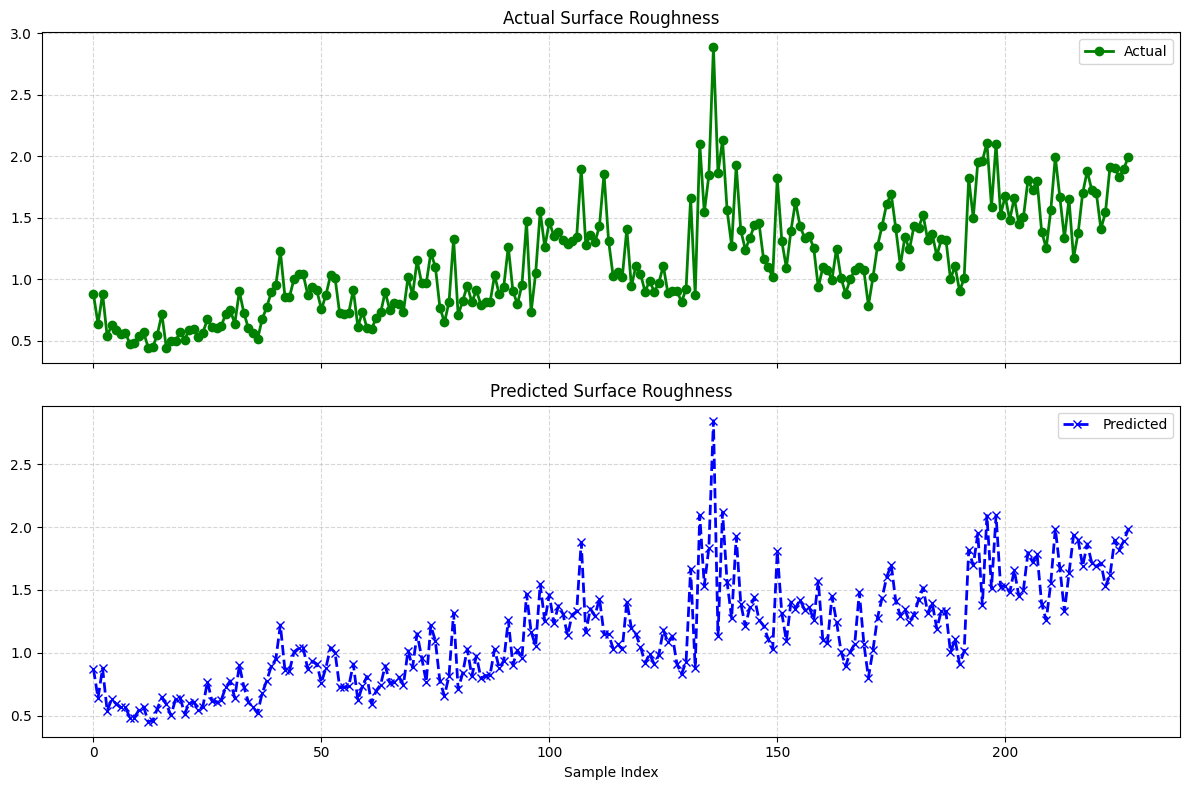

In [33]:
# Extract actual and predicted values from cleaned data
X_clean = best_metrics['X_clean']
y_actual = best_metrics['y_clean']
y_predicted = best_metrics['model'].predict(X_clean)


fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(y_actual, color='green', marker='o', label='Actual', linewidth=2)
axs[0].set_title('Actual Surface Roughness')
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[0].legend()

axs[1].plot(y_predicted, color='blue', marker='x', linestyle='--', label='Predicted', linewidth=2)
axs[1].set_title('Predicted Surface Roughness')
axs[1].grid(True, linestyle='--', alpha=0.5)
axs[1].legend()

plt.xlabel('Sample Index')
plt.tight_layout()
plt.show()

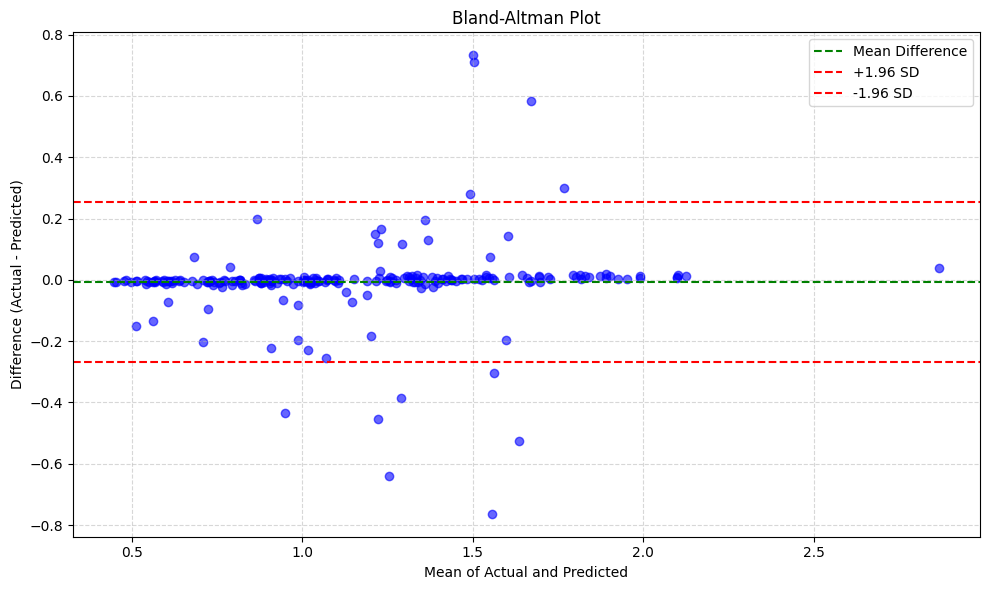

In [34]:
# Calculate mean,difference and standard deviation.
mean_values = (y_actual + y_predicted) / 2
diff_values = y_actual - y_predicted
mean_diff = np.mean(diff_values)
std_diff = np.std(diff_values)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(mean_values, diff_values, color='blue', alpha=0.6)
plt.axhline(mean_diff, color='green', linestyle='--', label='Mean Difference')
plt.axhline(mean_diff + 1.96*std_diff, color='red', linestyle='--', label='+1.96 SD')
plt.axhline(mean_diff - 1.96*std_diff, color='red', linestyle='--', label='-1.96 SD')

plt.title('Bland-Altman Plot')
plt.xlabel('Mean of Actual and Predicted')
plt.ylabel('Difference (Actual - Predicted)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()